# Identify Matching of Features

Objective:
- Visualiza features of same dataset to identify matching patterns 

In [55]:
import os
import sys
import xarray as xr
import dask
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata


In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

c:\Users\marti\Desktop\data\hw_extra


In [3]:
ua_mpi = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Amon/ua/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
ta_mpi = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Amon/ta/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
psl_mpi = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
tos_mpi = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

In [4]:
ua_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Amon/ua/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
ta_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Amon/ta/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
psl_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
tos_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

In [5]:
ua_gfdl = xr.open_mfdataset("data/GFDL-ESM4/historical/Amon/ua/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
ta_gfdl = xr.open_mfdataset("data/GFDL-ESM4/historical/Amon/ta/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
psl_gfdl = xr.open_mfdataset("data/GFDL-ESM4/historical/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
tos_gfdl = xr.open_mfdataset("data/GFDL-ESM4/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

In [6]:
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")
data_msl = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")

In [7]:
ref_period = [1980,2010]

## Data processing

In [8]:
def regrid_tos_ocean_curvilinear(ds):
    tos = ds["tos"]  # (time, j, i)
    lat2d = ds["latitude"].values
    lon2d = ds["longitude"].values
    time = ds["time"]

    # === Flatten source grid and build KDTree ===
    source_points = np.column_stack((lat2d.ravel(), lon2d.ravel()))
    tree = cKDTree(source_points)

    # === Create regular grid ===
    lat_new = np.arange(-90, 90.5, 0.5)
    lon_new = np.arange(0, 360, 0.5)
    lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)
    target_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    # === Map target points to nearest source points ===
    _, idx = tree.query(target_points)
    j_src, i_src = np.unravel_index(idx, lat2d.shape)

    # === Use broadcasting to grab all times in one shot ===
    tos_values = tos.values + 273  # shape (time, j, i) + to Kelvin
    tos_interp = tos_values[:, j_src, i_src]  # shape (time, n_points)
    tos_interp = tos_interp.reshape(len(time), len(lat_new), len(lon_new))

    # === Build xarray Dataset ===
    tos_da = xr.DataArray(
        tos_interp,
        dims=("time", "latitude", "longitude"),
        coords={
            "time": time,
            "latitude": lat_new,
            "longitude": lon_new,
        },
        name="tos"
    )
    tos_da.attrs = ds["tos"].attrs

    tos_e3_regridded = xr.Dataset({"tos": tos_da})
    tos_e3_regridded.attrs = ds.attrs

    return tos_e3_regridded

### MPI preprocess 

In [9]:
ua_mpi = ua_mpi.rename({
    "lat": "latitude",
    "lon": "longitude"
})
ta_mpi = ta_mpi.rename({
    "lat": "latitude",
    "lon": "longitude"
})
psl_mpi = psl_mpi.rename({
    "lat": "latitude",
    "lon": "longitude"
})

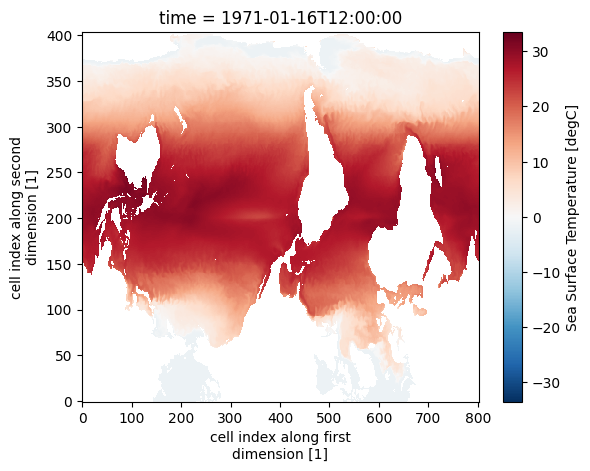

In [10]:
tos_mpi.isel(time=0).tos.plot()

In [11]:
tos_mpi_regridded = regrid_tos_ocean_curvilinear(tos_mpi)

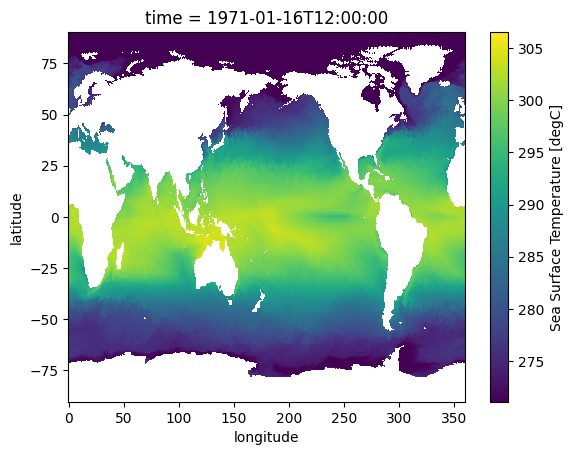

In [12]:
tos_mpi_regridded.isel(time=0).tos.plot()

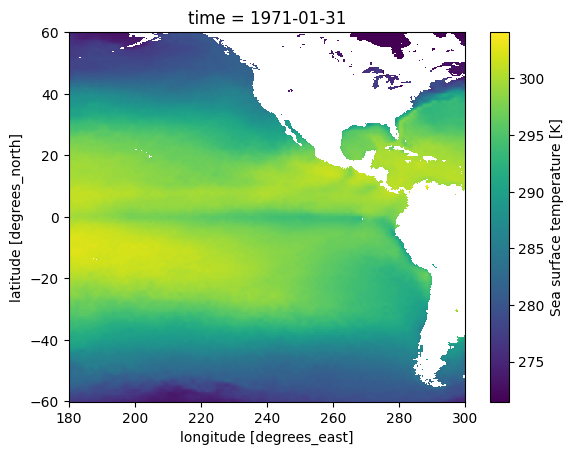

In [13]:
data_single.sst.isel(time=0).plot()

### EC-Earth3 Preprocess

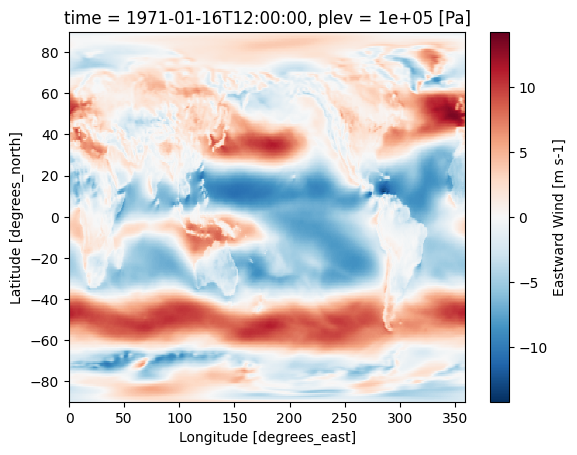

In [14]:
ua_e3.isel(time=0,plev=0).ua.plot()

In [15]:
ua_e3 = ua_e3.rename({
    "lat": "latitude",
    "lon": "longitude"
})
ta_e3 = ta_e3.rename({
    "lat": "latitude",
    "lon": "longitude"
})
psl_e3 = psl_e3.rename({
    "lat": "latitude",
    "lon": "longitude"
})

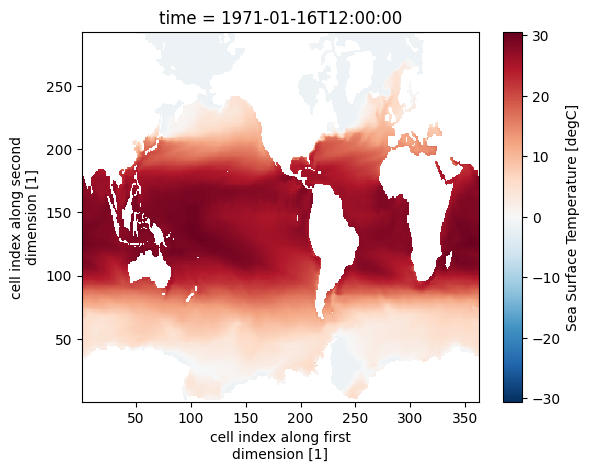

In [16]:
tos_e3.isel(time=0).tos.plot()

In [17]:
tos_e3_regridded = regrid_tos_ocean_curvilinear(tos_e3)

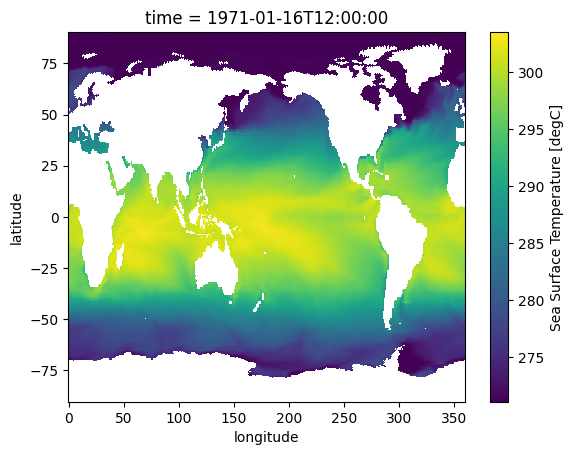

In [18]:
tos_e3_regridded.isel(time=0).tos.plot()

### GFDL-ESM4 Preprocess

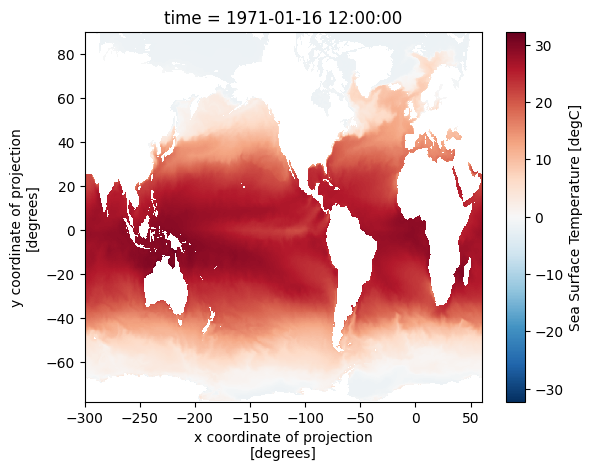

In [59]:
tos_gfdl.isel(time=0).tos.plot()

In [20]:

from scipy.spatial import cKDTree

# === Load data ===
tos_gfdl = xr.open_mfdataset("data/GFDL-ESM4/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

ds = tos_gfdl
lat_res, lon_res = 0.5, 0.5
tos = ds["tos"]  # (time, y, x)
lat2d = ds["lat"].values  # (y, x)
lon2d = ds["lon"].values  # (y, x)
time = ds["time"]

tos_sample = tos.isel(time=0).values
valid_mask = (
    ~np.isnan(lat2d) &
    ~np.isnan(lon2d) &
    ~np.isnan(tos_sample)
)

# === Ensure longitudes are in 0–360 (optional but helps) ===
lon2d = lon2d % 360

# === Build KDTree from valid points only ===
source_points = np.column_stack((lat2d[valid_mask], lon2d[valid_mask]))
tree = cKDTree(source_points)

# === Target grid ===
lat_new = np.arange(-90, 90.5, 0.5)
lon_new = np.arange(0, 360, 0.5)
lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)

target_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))
_, idx = tree.query(target_points)

# Map to valid (y,x) positions
flat_valid_indices = np.flatnonzero(valid_mask)
mapped_flat_index = flat_valid_indices[idx]
y_idx, x_idx = np.unravel_index(mapped_flat_index, lat2d.shape)

# === APPLY MAPPING TO ALL TIME STEPS ===
tos_values = tos.values  # shape: (time, y, x)
tos_interp = tos_values[:, y_idx, x_idx]  # shape: (time, n_points)
tos_interp = tos_interp.reshape(len(time), len(lat_new), len(lon_new))  # (time, lat, lon)

# === WRAP INTO XARRAY OBJECT ===
tos_da = xr.DataArray(
    tos_interp,
    dims=("time", "lat", "lon"),
    coords={
        "time": time,
        "lat": lat_new,
        "lon": lon_new
    },
    name="tos"
)
tos_da.attrs = tos.attrs

ds_out = xr.Dataset({"tos": tos_da})
ds_out.attrs = ds.attrs

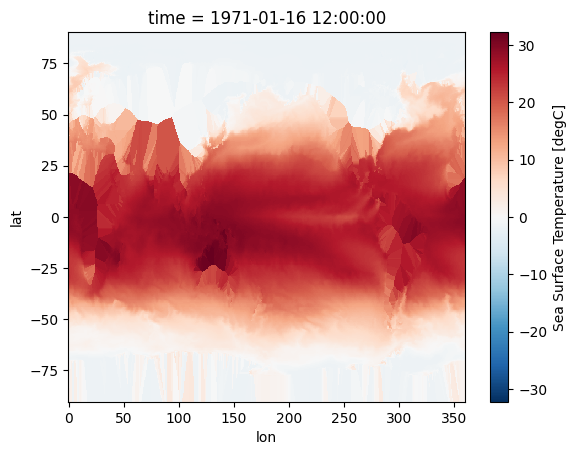

In [21]:
ds_out.isel(time=0).tos.plot()

In [56]:
def regrid_with_existing_coordinates(ds, resolution=0.5, mask_land=True, max_distance=None):
    """
    Regrid netCDF data using existing lat/lon coordinate variables.
    
    This function works when your netCDF file already contains lat/lon coordinates
    but they're stored as 2D arrays rather than 1D coordinate arrays.
    
    Parameters:
    -----------
    input_file : str
        Path to input netCDF file
    output_file : str
        Path for output netCDF file
    resolution : float
        Grid resolution in degrees (default: 0.5)
    """
    
    # Check if we have lat/lon variables
    if 'lat' not in ds.variables or 'lon' not in ds.variables:
        raise ValueError("Dataset must contain 'lat' and 'lon' variables")
    
    # Get the lat/lon coordinates
    # These are likely 2D arrays with dimensions (y, x)
    lat_2d = ds['lat'].values
    lon_2d = ds['lon'].values
    
    print(f"Original grid shape: {lat_2d.shape}")
    print(f"Latitude range: {np.min(lat_2d):.2f} to {np.max(lat_2d):.2f}")
    print(f"Longitude range: {np.min(lon_2d):.2f} to {np.max(lon_2d):.2f}")
    
    # Handle longitude wrapping (if longitudes go from -180 to 180)
    # Convert to 0-360 if needed for consistency
    if np.min(lon_2d) < 0:
        print("Converting longitude from -180:180 to 0:360 range...")
        lon_2d = np.where(lon_2d < 0, lon_2d + 360, lon_2d)
    
    # Define target grid aligned to resolution boundaries
    lon_min = np.floor(np.min(lon_2d) / resolution) * resolution
    lon_max = np.ceil(np.max(lon_2d) / resolution) * resolution
    lat_min = np.floor(np.min(lat_2d) / resolution) * resolution
    lat_max = np.ceil(np.max(lat_2d) / resolution) * resolution
    
    # Create target coordinate arrays
    lon_target = np.arange(lon_min, lon_max + resolution/2, resolution)
    lat_target = np.arange(lat_min, lat_max + resolution/2, resolution)
    
    # Create target meshgrid
    LON_target, LAT_target = np.meshgrid(lon_target, lat_target)
    
    # Set up distance threshold for masking
    if max_distance is None:
        max_distance = resolution * 2  # Default: twice the resolution
    
    print(f"Using land masking: {mask_land}")
    if mask_land:
        print(f"Maximum interpolation distance: {max_distance:.2f}°")
    
    # Prepare source points for interpolation
    source_points = np.column_stack((lon_2d.flatten(), lat_2d.flatten()))
    target_points = np.column_stack((LON_target.flatten(), LAT_target.flatten()))
    
    # Process data variables
    regridded_vars = {}
    
    for var_name in ds.data_vars:
        var = ds[var_name]
        
        # Skip coordinate bounds variables
        if 'bnds' in var_name.lower() or 'bounds' in var_name.lower():
            continue
            
        print(f"Processing variable: {var_name}")
        
        # Check if variable has x,y dimensions (or y,x)
        if ('x' in var.dims and 'y' in var.dims) or ('lat' in var.dims and 'lon' in var.dims):
            
            if len(var.dims) == 2:  # Just spatial dimensions
                var_data = var.values
                
                # Remove NaN values
                valid_mask = ~np.isnan(var_data.flatten())
                if np.sum(valid_mask) == 0:
                    print(f"  Warning: All values are NaN for {var_name}")
                    continue
                
                valid_points = source_points[valid_mask]
                valid_values = var_data.flatten()[valid_mask]
                
                # Interpolate
                print(f"  Interpolating {np.sum(valid_mask)} valid points...")
                regridded_flat = griddata(
                    valid_points, valid_values,
                    target_points,
                    method='linear',
                    fill_value=np.nan
                )
                
                regridded = regridded_flat.reshape(LON_target.shape)
                
                if mask_land:
                    # Apply ocean mask: only keep values where we have nearby ocean data
                    print(f"  Applying ocean mask...")
                    
                    # Method 1: Use nearest neighbor to determine ocean/land
                    nearest_flat = griddata(
                        valid_points, valid_values,
                        target_points,
                        method='nearest',
                        fill_value=np.nan
                    )
                    nearest = nearest_flat.reshape(LON_target.shape)
                    basic_mask = ~np.isnan(nearest)
                    
                    # Method 2: Distance-based masking
                    # Calculate minimum distance to valid ocean points
                    from scipy.spatial.distance import cdist
                    
                    distances = cdist(target_points, valid_points, metric='euclidean')
                    min_distances = np.min(distances, axis=1)
                    distance_mask = min_distances <= max_distance
                    distance_mask = distance_mask.reshape(LON_target.shape)
                    
                    # Combine both masks
                    ocean_mask = basic_mask & distance_mask
                    regridded = np.where(ocean_mask, regridded, np.nan)
                    
                    ocean_points = np.sum(~np.isnan(regridded))
                    total_points = regridded.size
                    print(f"  Ocean points: {ocean_points:,} / {total_points:,} ({100*ocean_points/total_points:.1f}%)")
                
                regridded_vars[var_name] = (['lat', 'lon'], regridded)
                
            elif len(var.dims) == 3:  # Has time dimension
                # Find the time dimension
                time_dim = None
                for dim in var.dims:
                    if dim not in ['x', 'y', 'lat', 'lon']:
                        time_dim = dim
                        break
                
                if time_dim is None:
                    print(f"  Warning: Could not identify time dimension for {var_name}")
                    continue
                
                time_coord = ds[time_dim]
                n_time = len(time_coord)
                
                print(f"  Processing {n_time} time steps...")
                
                regridded_data = []
                
                for t in range(n_time):
                    if t % 50 == 0:  # Progress indicator
                        print(f"    Time step {t+1}/{n_time}")
                    
                    # Extract data for this time step
                    if time_dim == 'time':
                        var_slice = var.isel(time=t).values
                    else:
                        var_slice = var.isel({time_dim: t}).values
                    
                    # Remove NaN values
                    valid_mask = ~np.isnan(var_slice.flatten())
                    
                    if np.sum(valid_mask) > 0:
                        valid_points = source_points[valid_mask]
                        valid_values = var_slice.flatten()[valid_mask]
                        
                        # Interpolate
                        regridded_flat = griddata(
                            valid_points, valid_values,
                            target_points,
                            method='nearest',
                            fill_value=np.nan
                        )
                        
                        regridded = regridded_flat.reshape(LON_target.shape)
                        
                        # Apply ocean mask using nearest neighbor
                        nearest_flat = griddata(
                            valid_points, valid_values,
                            target_points,
                            method='nearest',
                            fill_value=np.nan
                        )
                        nearest = nearest_flat.reshape(LON_target.shape)
                        ocean_mask = ~np.isnan(nearest)
                        regridded = np.where(ocean_mask, regridded, np.nan)
                        
                    else:
                        regridded = np.full(LON_target.shape, np.nan)
                    
                    regridded_data.append(regridded)
                
                regridded_data = np.array(regridded_data)
                regridded_vars[var_name] = ([time_dim, 'lat', 'lon'], regridded_data)
        
        else:
            print(f"  Skipping {var_name} - no spatial dimensions")
    
    # Create coordinates for output dataset
    coords = {
        'lon': lon_target,
        'lat': lat_target
    }
    
    # Add non-spatial coordinates
    for coord_name in ds.coords:
        if coord_name not in ['x', 'y', 'lat', 'lon']:
            coords[coord_name] = ds[coord_name]
    
    # Create output dataset
    ds_regridded = xr.Dataset(regridded_vars, coords=coords)
    
    # Convert longitude back to -180:180 if that was the original format
    if np.min(ds['lon'].values) < 0:
        print("Converting output longitude back to -180:180 range...")
        ds_regridded = ds_regridded.assign_coords(
            lon=np.where(ds_regridded.lon > 180, ds_regridded.lon - 360, ds_regridded.lon)
        )
        # Sort by longitude to maintain order
        ds_regridded = ds_regridded.sortby('lon')
    
    # Copy attributes
    ds_regridded.attrs = ds.attrs.copy()
    ds_regridded.attrs['regridded'] = f'Regridded to {resolution}° regular grid'
    ds_regridded.attrs['regridding_method'] = 'linear interpolation'
    ds_regridded.attrs['source_grid'] = f'{lat_2d.shape[0]} x {lat_2d.shape[1]} irregular grid'
    ds_regridded.attrs['target_grid'] = f'{len(lat_target)} x {len(lon_target)} regular grid'
    
    # Copy variable attributes
    for var_name in regridded_vars:
        if var_name in ds.data_vars:
            ds_regridded[var_name].attrs = ds[var_name].attrs.copy()
    
    # Add coordinate attributes
    ds_regridded['lon'].attrs = {
        'long_name': 'longitude',
        'units': 'degrees_east',
        'axis': 'X',
        'standard_name': 'longitude'
    }
    ds_regridded['lat'].attrs = {
        'long_name': 'latitude', 
        'units': 'degrees_north',
        'axis': 'Y',
        'standard_name': 'latitude'
    }

    
    print("Regridding complete!")
    
    # Print summary
    print(f"\nSUMMARY:")
    print(f"Original grid: {lat_2d.shape[0]} x {lat_2d.shape[1]} = {lat_2d.size:,} points")
    print(f"Regridded grid: {len(lat_target)} x {len(lon_target)} = {len(lat_target) * len(lon_target):,} points")
    print(f"Resolution: {resolution}° x {resolution}°")
    
    return ds_regridded

In [57]:
ds_out = regrid_with_existing_coordinates(tos_gfdl)

Original grid shape: (576, 720)
Latitude range: -77.91 to 89.88
Longitude range: -300.00 to 60.00
Converting longitude from -180:180 to 0:360 range...
Using land masking: True
Maximum interpolation distance: 1.00°
Processing variable: tos
  Processing 528 time steps...
    Time step 1/528
    Time step 51/528
    Time step 101/528
    Time step 151/528
    Time step 201/528
    Time step 251/528
    Time step 301/528
    Time step 351/528
    Time step 401/528
    Time step 451/528
    Time step 501/528
Converting output longitude back to -180:180 range...
Regridding complete!

SUMMARY:
Original grid: 576 x 720 = 414,720 points
Regridded grid: 337 x 721 = 242,977 points
Resolution: 0.5° x 0.5°


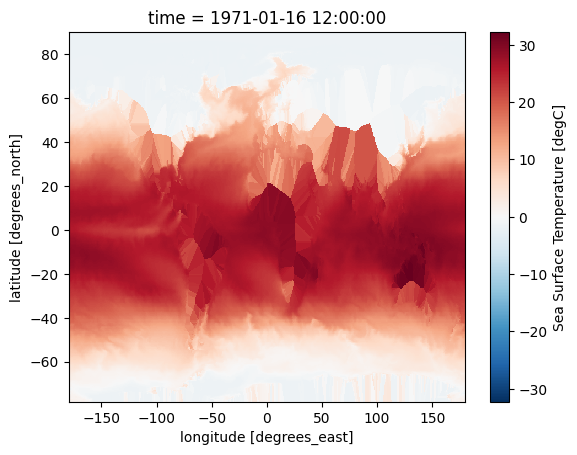

In [58]:
ds_out.isel(time=0).tos.plot()

## Features definition

In [24]:
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_pressure": [260, 284, -44, -17], #study max over time and define region
    "chile" : [286, 288, -42, -33]
    #"advección": [280, 285, -37, -30]
}

In [25]:
nino34_mpi = AnomaliesIndex(tos_mpi_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_mpi = AnomaliesIndex(tos_mpi_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")

nino34_e3 = AnomaliesIndex(tos_e3_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_e3 = AnomaliesIndex(tos_e3_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")


nino34_era5 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_era5 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")


In [26]:
ocean_cyclone_era5 = MaxIndex(data_msl, [1972,2022], variables=["MSL"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
ocean_cyclone_mpi = MaxIndex(psl_mpi, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
ocean_cyclone_e3 = MaxIndex(psl_e3, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)


In [27]:
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}

In [28]:
mslp_indices_era5 = [AnomaliesIndex(data_msl, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_vaguada.items()]
mslp_indices_mpi = [AnomaliesIndex(psl_mpi, [1972,2022], reference_period=ref_period, variables=["psl"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_vaguada.items()]
mslp_indices_e3 = [AnomaliesIndex(psl_e3, [1972,2022], reference_period=ref_period, variables=["psl"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_vaguada.items()]

In [29]:
data_850["adv"] = -1*data_850.u*data_850.t

adv_850_mpi = -1*ua_mpi.sel(plev=85000).ua*ta_mpi.sel(plev=85000).ta
adv_850_mpi = xr.Dataset({"adv": adv_850_mpi})

adv_850_e3 = -1*ua_e3.sel(plev=85000).ua*ta_e3.sel(plev=85000).ta
adv_850_e3 = xr.Dataset({"adv": adv_850_e3})


In [30]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

In [31]:
advection_indices_mpi = [AnomaliesIndex(adv_850_mpi, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(adv_850_mpi, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
advection_indices_e3 = [AnomaliesIndex(adv_850_e3, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(adv_850_e3, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
advection_indices_era5 = [AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]

In [32]:
boxes_chile_winds = {
    "chile_u_norte": [287.5, 289.5, -37, -33],
    "chile_u_sur": [286.5, 288.5, -42, -37],
    "A_arg": [286, 292, -52, -40]
}
chile_wind_mpi = ua_mpi.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
                           plev=85000).ua.mean(dim=["latitude","longitude"]
                           )

chile_wind_e3 = ua_e3.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
                           plev=85000).ua.mean(dim=["latitude","longitude"]
                           )

chile_wind_era5 = data_850.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1])
                           ).u.mean(dim=["latitude","longitude"])

## Matching patterns

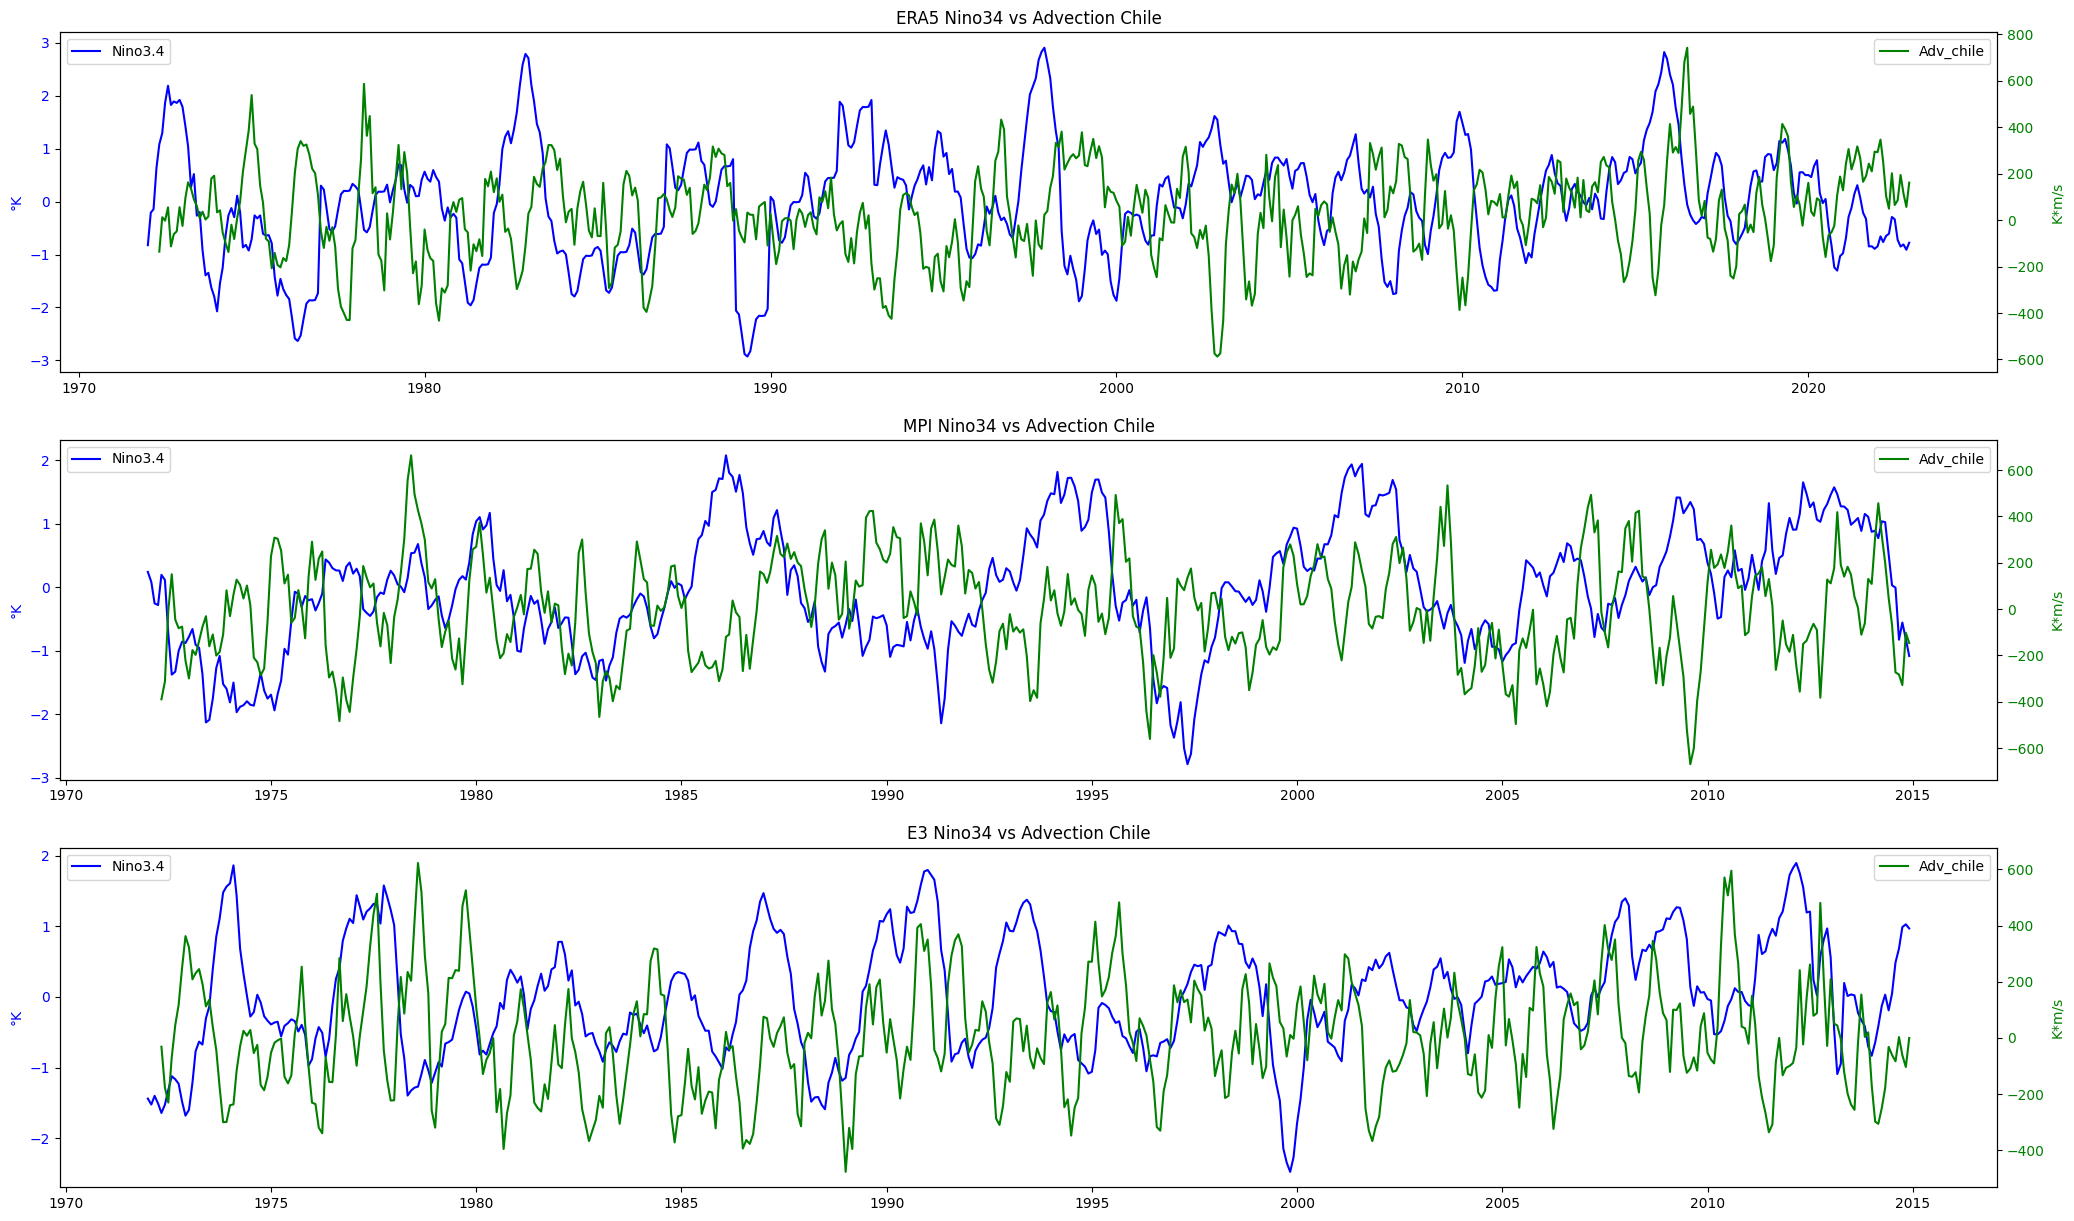

In [33]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = nino34_era5.get_index("SST")
index2_era5 = advection_indices_era5[0].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[0].plot(index1_era5.index, index1_era5["sst"], color='blue', label='Nino3.4')
ax1[0].set_ylabel('°K', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(index2_era5.index, index2_era5["adv"], color='green', label='Adv_chile')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[0].set_title("ERA5 Nino34 vs Advection Chile")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_mpi = nino34_mpi.get_index("tos")
index2_mpi = advection_indices_mpi[0].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[1].plot(index1_mpi.index, index1_mpi["tos"], color='blue', label='Nino3.4')
ax1[1].set_ylabel('°K', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(index2_mpi.index, index2_mpi["adv"], color='green', label='Adv_chile')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[1].set_title("MPI Nino34 vs Advection Chile")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_e3 = nino34_e3.get_index("tos")
index2_e3 = advection_indices_e3[0].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[2].plot(index1_e3.index, index1_e3["tos"], color='blue', label='Nino3.4')
ax1[2].set_ylabel('°K', color='blue')
ax1[2].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[2].twinx()
ax2.plot(index2_e3.index, index2_e3["adv"], color='green', label='Adv_chile')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[2].set_title("E3 Nino34 vs Advection Chile")
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')


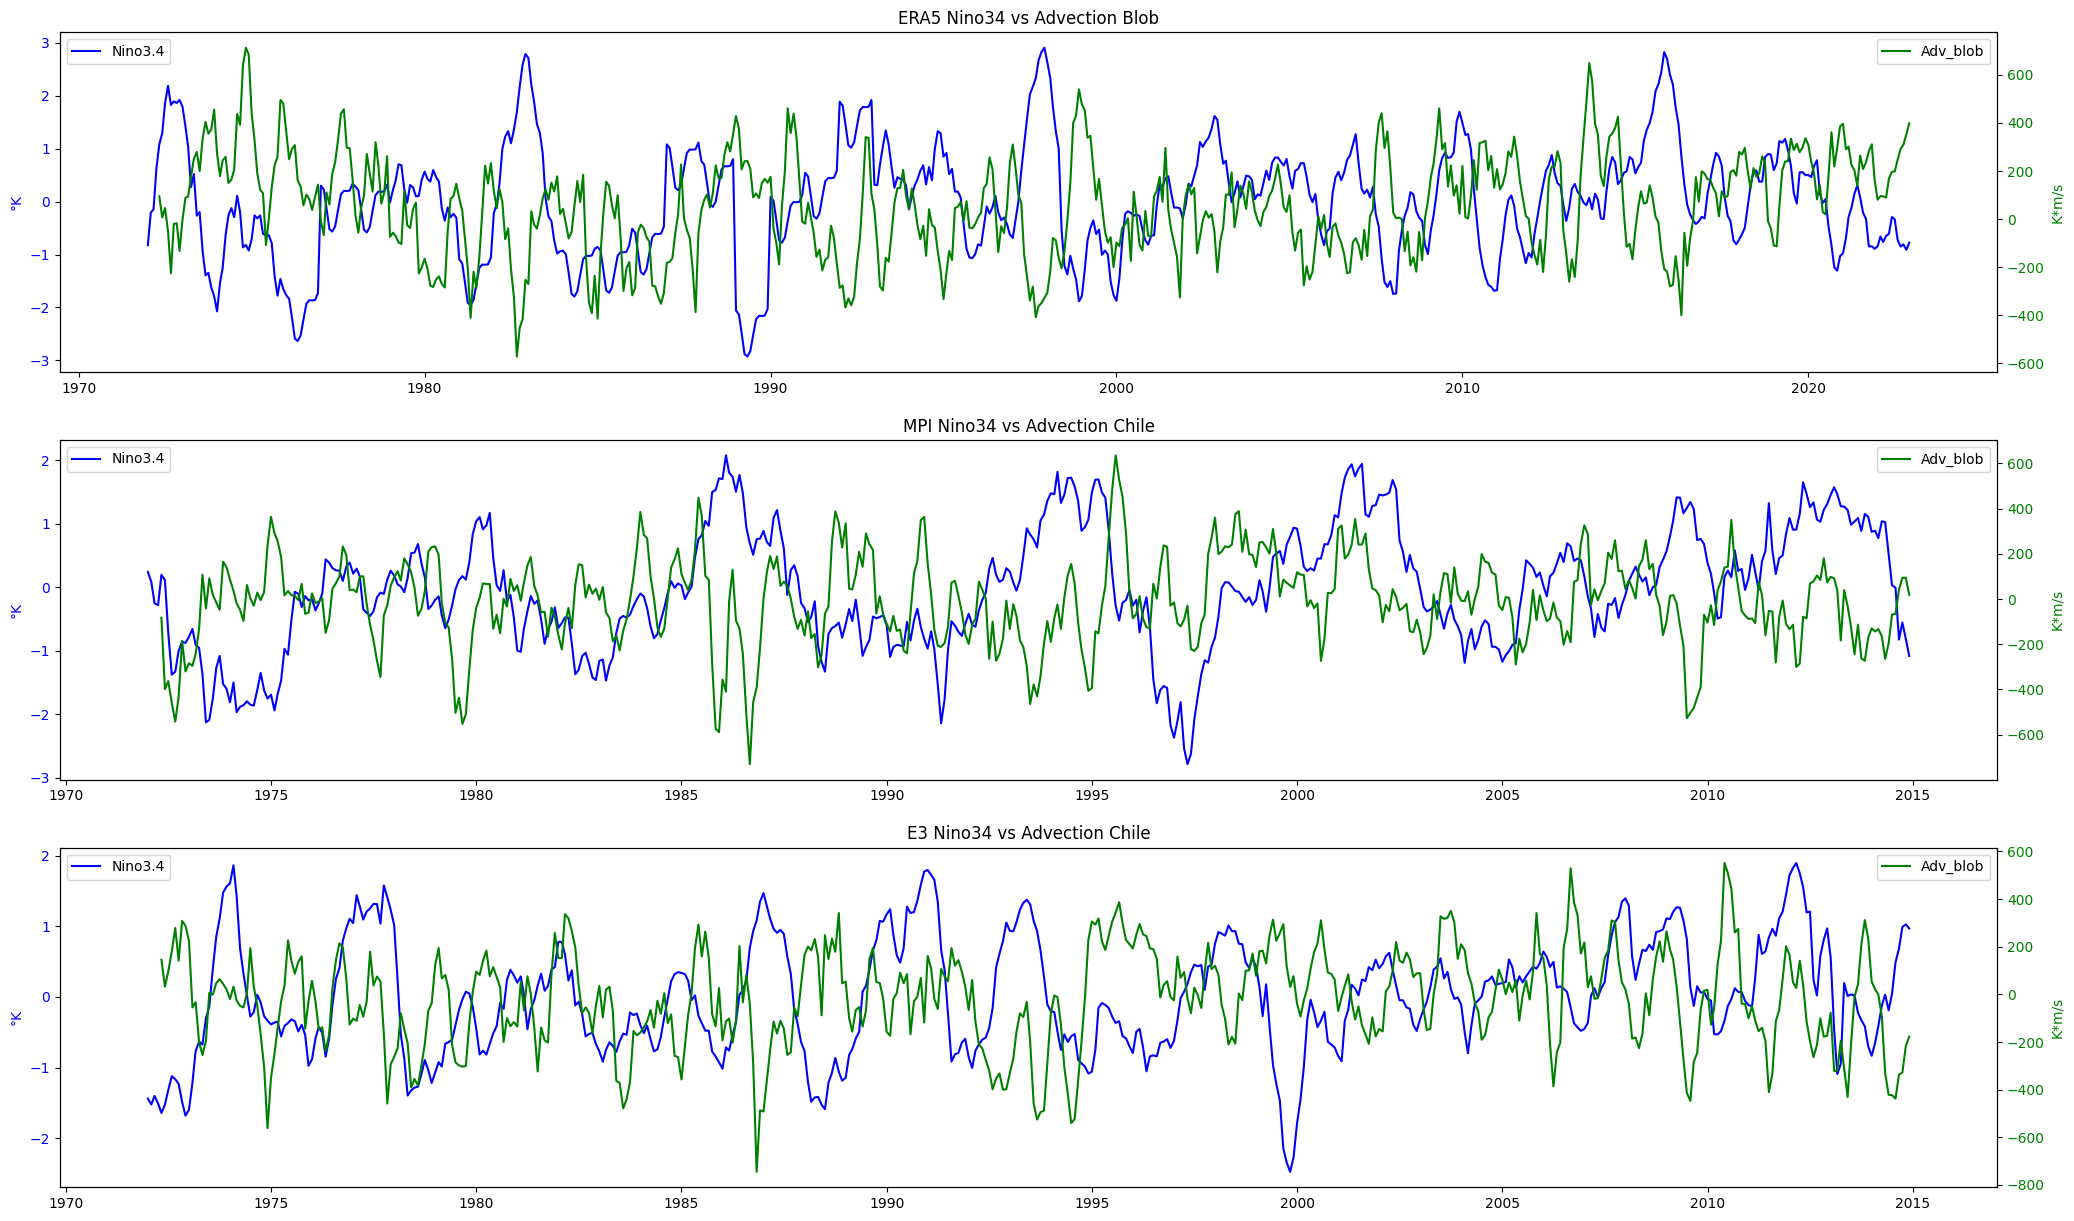

In [41]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = nino34_era5.get_index("SST")
index2_era5 = advection_indices_era5[1].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[0].plot(index1_era5.index, index1_era5["sst"], color='blue', label='Nino3.4')
ax1[0].set_ylabel('°K', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(index2_era5.index, index2_era5["adv"], color='green', label='Adv_blob')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[0].set_title("ERA5 Nino34 vs Advection Blob")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_mpi = nino34_mpi.get_index("tos")
index2_mpi = advection_indices_mpi[1].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[1].plot(index1_mpi.index, index1_mpi["tos"], color='blue', label='Nino3.4')
ax1[1].set_ylabel('°K', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(index2_mpi.index, index2_mpi["adv"], color='green', label='Adv_blob')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[1].set_title("MPI Nino34 vs Advection Chile")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_e3 = nino34_e3.get_index("tos")
index2_e3 = advection_indices_e3[1].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[2].plot(index1_e3.index, index1_e3["tos"], color='blue', label='Nino3.4')
ax1[2].set_ylabel('°K', color='blue')
ax1[2].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[2].twinx()
ax2.plot(index2_e3.index, index2_e3["adv"], color='green', label='Adv_blob')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[2].set_title("E3 Nino34 vs Advection Chile")
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')



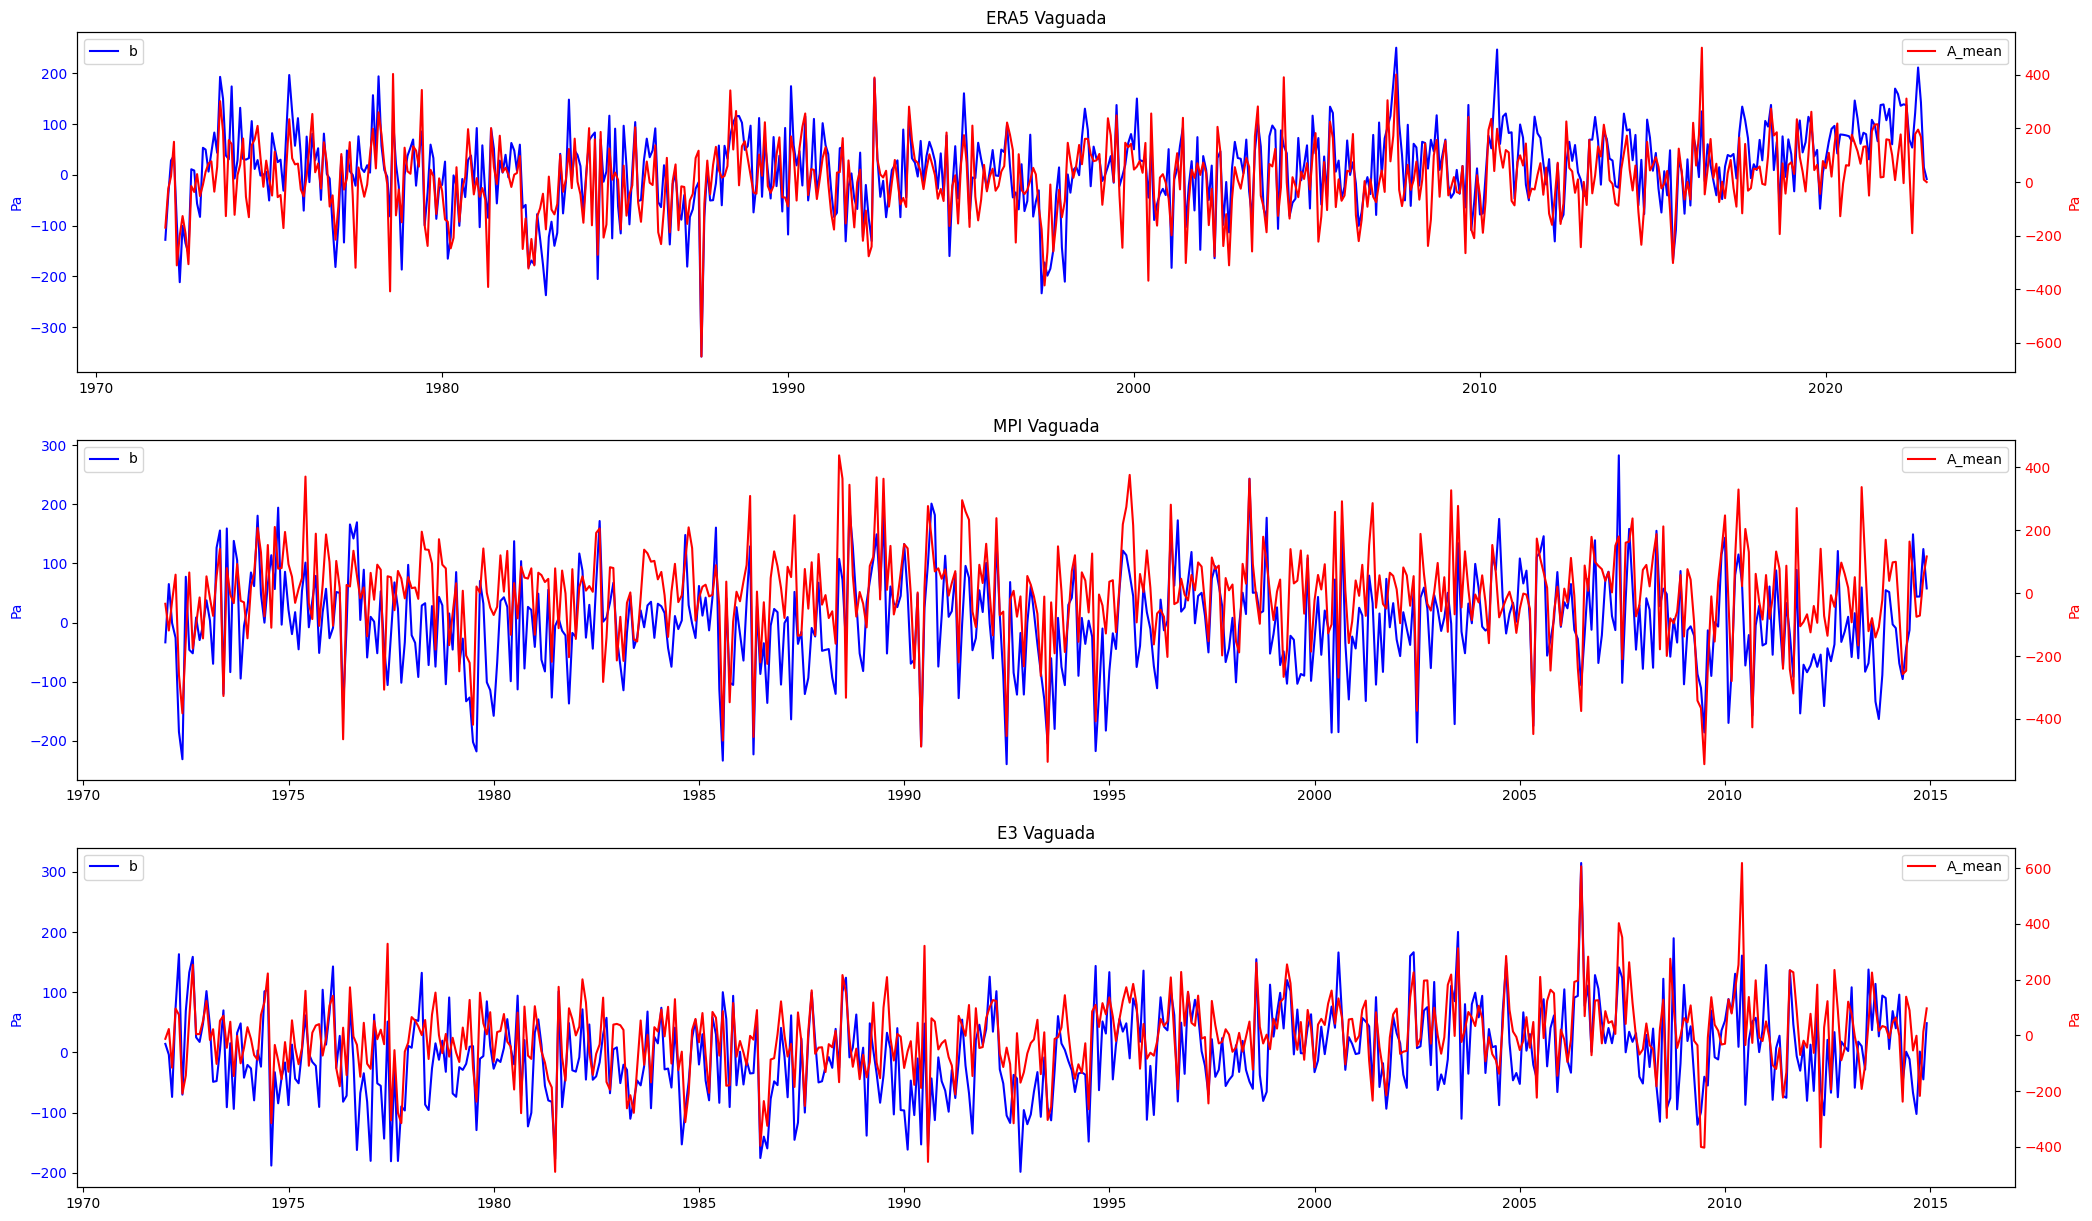

In [35]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = mslp_indices_era5[0].get_index("MSL")
index2_era5 = mslp_indices_era5[1].get_index("MSL")
index3_era5 = mslp_indices_era5[2].get_index("MSL")


# Plot first series
ax1[0].plot(index1_era5.index, index1_era5["msl"], color='blue', label='b')
ax1[0].set_ylabel('Pa', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(index2_era5.index, (index2_era5["msl"]+index3_era5["msl"])/2, color='red', label='A_mean')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[0].set_title("ERA5 Vaguada")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_mpi = mslp_indices_mpi[0].get_index("psl")
index2_mpi = mslp_indices_mpi[1].get_index("psl")
index3_mpi = mslp_indices_mpi[2].get_index("psl")


# Plot first series
ax1[1].plot(index1_mpi.index, index1_mpi["psl"], color='blue', label='b')
ax1[1].set_ylabel('Pa', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(index2_mpi.index, (index2_mpi["psl"]+index3_mpi["psl"])/2, color='red', label='A_mean')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[1].set_title("MPI Vaguada")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_e3 = mslp_indices_e3[0].get_index("psl")
index2_e3 = mslp_indices_e3[1].get_index("psl")
index3_e3 = mslp_indices_e3[2].get_index("psl")


# Plot first series
ax1[2].plot(index1_e3.index, index1_e3["psl"], color='blue', label='b')
ax1[2].set_ylabel('Pa', color='blue')
ax1[2].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[2].twinx()
ax2.plot(index2_e3.index, (index2_e3["psl"]+index3_e3["psl"])/2, color='red', label='A_mean')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[2].set_title("E3 Vaguada")
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')

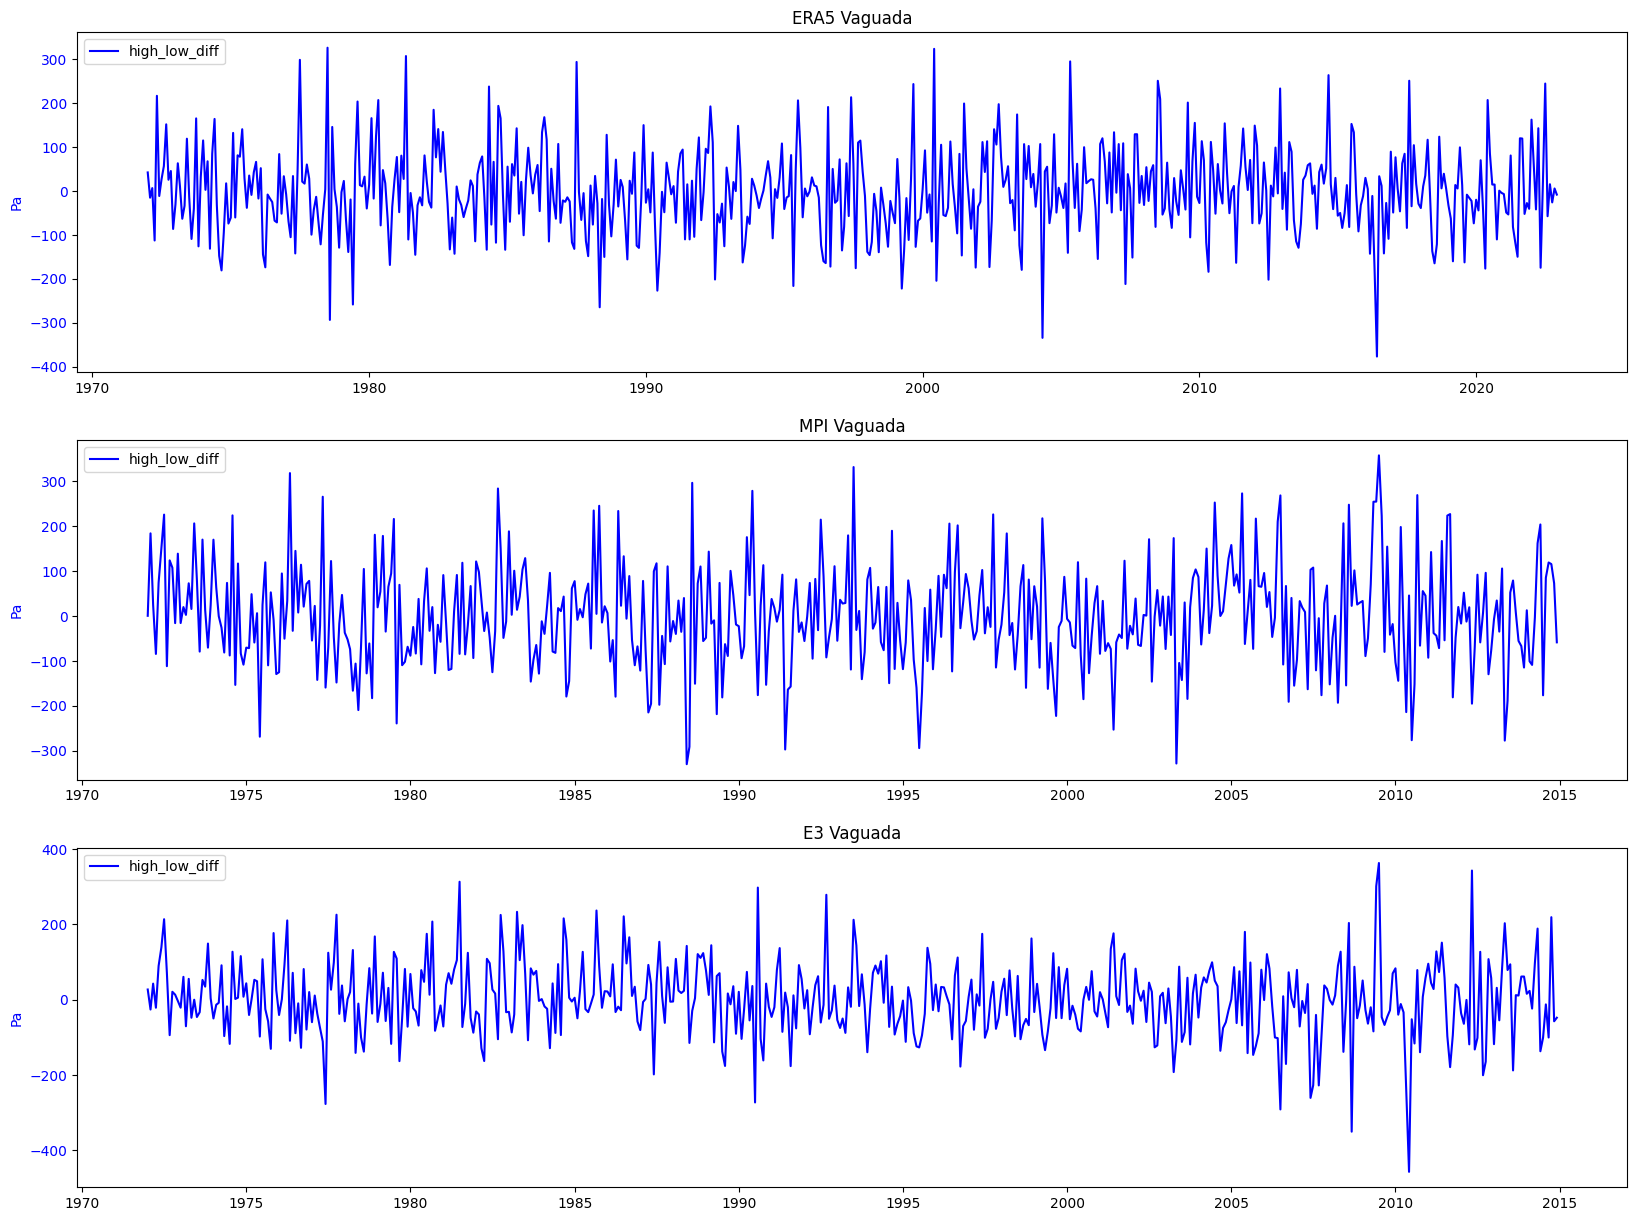

In [36]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(20, 15))

ax1 = ax1.flatten()

index1_era5 = mslp_indices_era5[0].get_index("MSL")
index2_era5 = mslp_indices_era5[1].get_index("MSL")
index3_era5 = mslp_indices_era5[2].get_index("MSL")

vaguada_era5 = index1_era5["msl"] - (index2_era5["msl"]+index3_era5["msl"])/2


# Plot first series
ax1[0].plot(index1_era5.index, vaguada_era5, color='blue', label='high_low_diff')
ax1[0].set_ylabel('Pa', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')


ax1[0].set_title("ERA5 Vaguada")
ax1[0].legend(loc='upper left')

index1_mpi = mslp_indices_mpi[0].get_index("psl")
index2_mpi = mslp_indices_mpi[1].get_index("psl")
index3_mpi = mslp_indices_mpi[2].get_index("psl")

vaguada_mpi = index1_mpi["psl"]- (index2_mpi["psl"]+index3_mpi["psl"])/2

# Plot first series
ax1[1].plot(index1_mpi.index, vaguada_mpi, color='blue', label='high_low_diff')
ax1[1].set_ylabel('Pa', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')
ax1[1].set_title("MPI Vaguada")
ax1[1].legend(loc='upper left')

index1_e3 = mslp_indices_e3[0].get_index("psl")
index2_e3 = mslp_indices_e3[1].get_index("psl")
index3_e3 = mslp_indices_e3[2].get_index("psl")

vaguada_e3 = index1_e3["psl"]- (index2_e3["psl"]+index3_e3["psl"])/2

# Plot first series
ax1[2].plot(index1_e3.index, vaguada_e3, color='blue', label='high_low_diff')
ax1[2].set_ylabel('Pa', color='blue')
ax1[2].tick_params(axis='y', labelcolor='blue')
ax1[2].set_title("E3 Vaguada")
ax1[2].legend(loc='upper left')

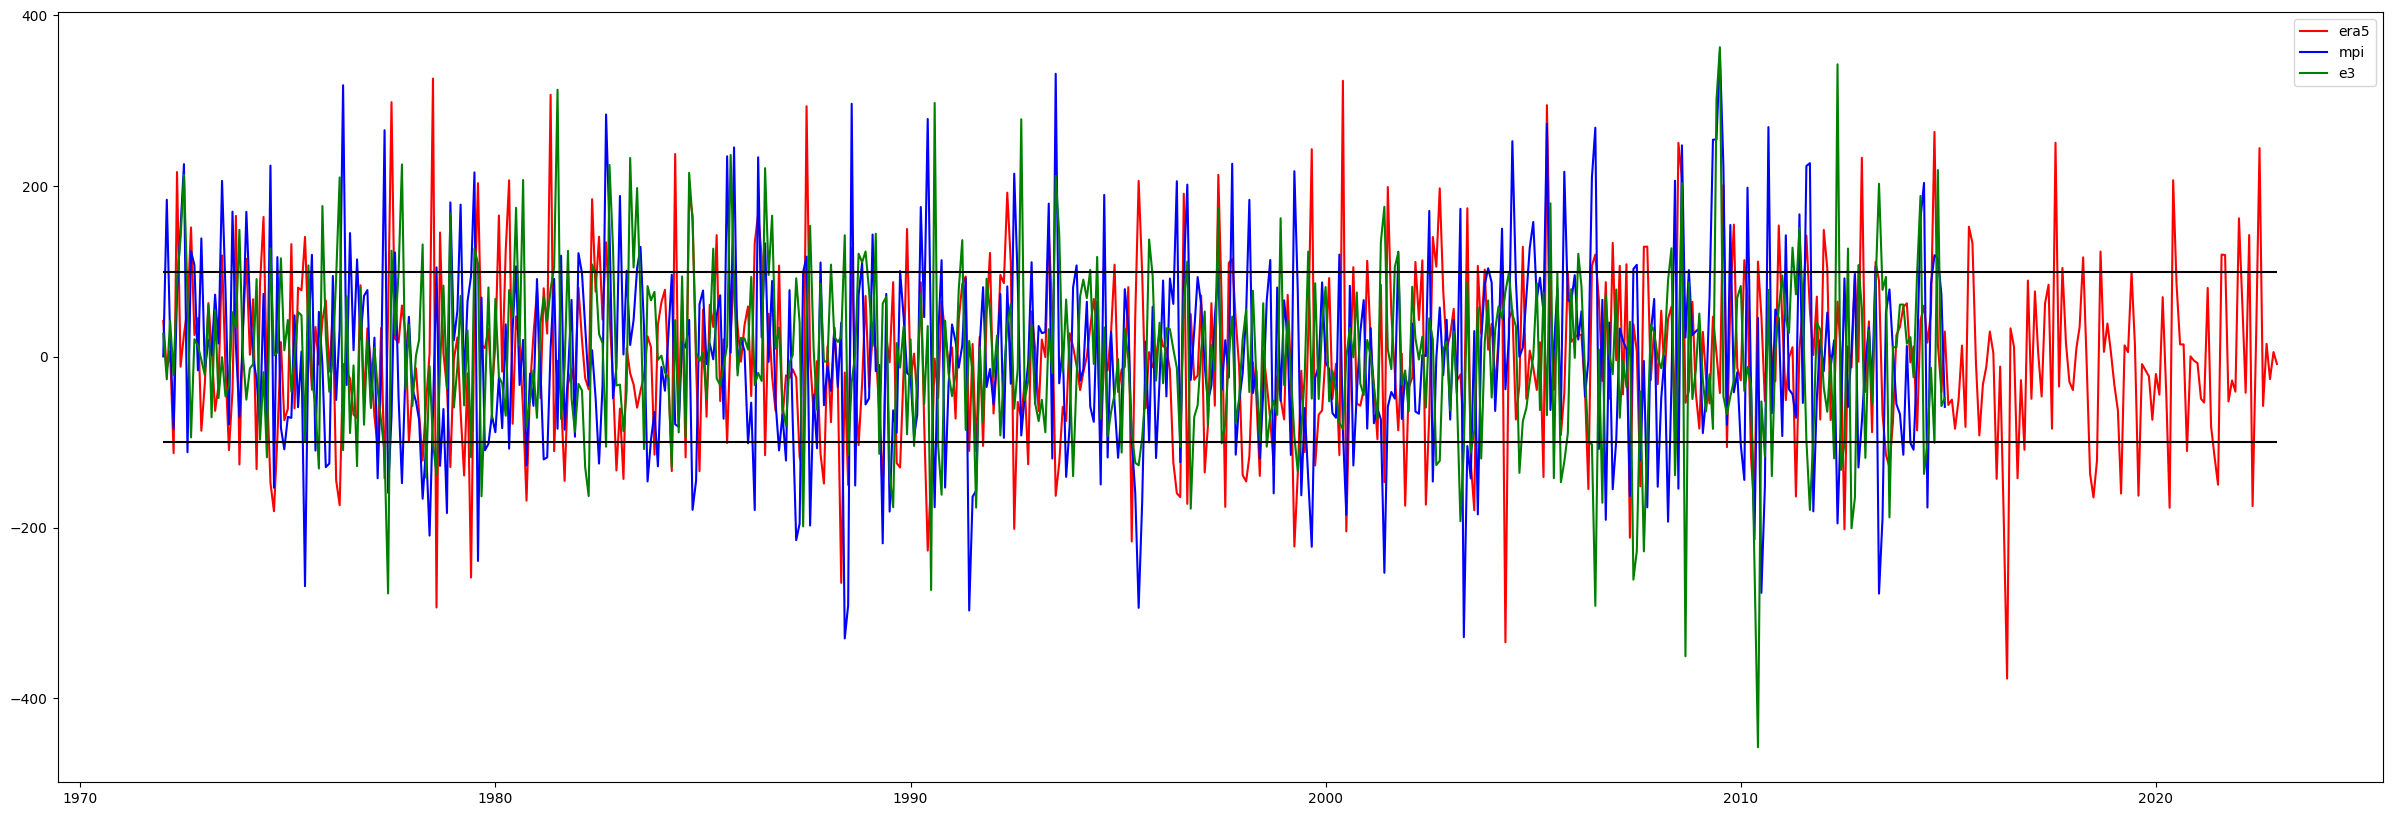

In [52]:
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(index1_era5.index, vaguada_era5, color='red', label='era5')
ax.plot(index1_mpi.index, vaguada_mpi, color='blue', label='mpi')
ax.plot(index1_e3.index, vaguada_e3, color='green', label='e3')

ax.hlines([-100,100], index1_era5.index[0], index1_era5.index[-1], colors="black")
plt.legend()
plt.show()


In [37]:
print(f" Vaguada events ERA5: {vaguada_era5[vaguada_era5<-100].count()}/{vaguada_era5.count()}")

 Vaguada events ERA5: 96/612


In [38]:
print(f" Vaguada events MPI: {vaguada_mpi[vaguada_mpi<-100].count()}/{vaguada_mpi.count()}")

 Vaguada events MPI: 94/516


In [39]:
print(f" Vaguada events E3: {vaguada_e3[vaguada_e3<-100].count()}/{vaguada_e3.count()}")

 Vaguada events E3: 69/516
